# BillSum Summarization - Longform Encoder-Decoder (LED)

## Load Dependencies

In [ ]:
import datasets
from transformers import LEDTokenizer, LEDForConditionalGeneration, AutoConfig, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

import evaluate
from tqdm import tqdm
import torch, gc
from itertools import islice

import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

import os
os.environ["WANDB_DISABLED"] = "true"

import warnings
warnings.filterwarnings("ignore")

from transformers import logging
logging.set_verbosity_error()

## Load BillSum Dataset

In [ ]:
billsum_train = datasets.load_dataset("json", data_files="billsum_data/us_train_data_final_OFFICIAL.jsonl")["train"]
billsum_test = datasets.load_dataset("json", data_files="billsum_data/us_test_data_final_OFFICIAL.jsonl")["train"]

print(billsum_test.shape)

(3269, 6)


# Text Separation and Splitting

The following functions split a bill into its main numbered sections and then further splits them based off of each lettered subsection. We are not splitting by each sentence because the text formmatting makes it difficult to split it that way.

In [ ]:
def split_bill_into_sections(text):
    # Normalize line breaks
    text = re.sub(r'\n+', '\n', text)

    # Ensure section headers start on a new line (case-insensitive)
    text = re.sub(r'(?<!\n)((SECTION|SEC)\.?\s*\d+\.)', r'\n\1', text, flags=re.IGNORECASE)

    # Match from each SECTION/SEC until the next one or end of text
    pattern = r'((?:SEC|SECTION)\.?\s*\d+\..*?)(?=(?:SEC|SECTION)\.?\s*\d+\.|\Z)'
    sections = re.findall(pattern, text, flags=re.DOTALL | re.IGNORECASE)

    if len(sections) == 0:
        return [text]

    return sections


def split_by_lettered_clause_with_linebreaks(text):
    # Insert a unique delimiter before (a), (b), ... only if they occur after a line break and spaces
    pattern = r'\n[ \t]*\([a-z]\)(?!\([a-zA-Z0-9]\))'
    split_text = re.split(f'({pattern})', text)

    # Recombine so that each clause includes its clause marker
    combined = []
    buffer = ''
    for part in split_text:
        if re.match(pattern, part):
            if buffer:
                combined.append(buffer.strip())
            buffer = part.lstrip('\n')
        else:
            buffer += part
    if buffer:
        combined.append(buffer.strip())

    res = [clause for clause in combined if clause]
    if res == []:
        return [text]
    return res


# helper function for splitting the bill into subsections
def split_bill(text):
    sections = split_bill_into_sections(text)
    nested_list = [split_by_lettered_clause_with_linebreaks(section) for section in sections]
    flat_list = [item for sublist in nested_list for item in sublist]
    return list(dict.fromkeys(flat_list)) # prevent duplicates

# Cluster Based Extraction

Below is a function for cluster based extraction. For the vectorization of our sentences we are using tfidf.

In [ ]:
def cluster_based_summary(sentences, num_clusters = 3):
    vectorizer = TfidfVectorizer(stop_words = 'english')
    X = vectorizer.fit_transform(sentences)

    # Adjust num_clusters if it's greater than the number of sentences or if X is empty
    if len(sentences) == 0:
        return []
    num_clusters = min(num_clusters, len(sentences))

    # Handle the case where X might have only one sample (resulting in a single cluster)
    if num_clusters == 1:
         return [sentences[0]]

    kmeans = KMeans(n_clusters = num_clusters, random_state = 0, n_init=10) # Add n_init for robustness
    kmeans.fit(X)

    # Find closest sentence to each cluster centroid
    summary_sentences = []
    for i in range(num_clusters):
        cluster_center = kmeans.cluster_centers_[i]
        cluster_indices = np.where(kmeans.labels_ == i)[0]

        # Check if the cluster is not empty
        if len(cluster_indices) > 0:
            cluster_vectors = X[cluster_indices].toarray()

            # Compute distances to centroid
            distances = np.linalg.norm(cluster_vectors - cluster_center, axis = 1)
            closest_index = cluster_indices[np.argmin(distances)]
            summary_sentences.append(sentences[closest_index])

    # Sort by original order
    # Only attempt to sort if summary_sentences is not empty
    if summary_sentences:
        summary_sentences.sort(key = lambda s: sentences.index(s))

    return summary_sentences

# Example on the first bill

Below we perform cluster based extraction on the first bill in the test dataset. We split the bill into subsections as mentioned above and defined eight cluters. The result is an eight sentence summary of the bill.

In [ ]:
# Example
test_split = split_bill(billsum_test[0]["text"])
cluster_based_summary(test_split, 18)

['SECTION 1. ENVIRONMENTAL INFRASTRUCTURE.',
 "(a) Jackson County, Mississippi.--Section 219 of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended--\n        (1) in subsection (c), by striking paragraph (5) and inserting \n    the following:\n        ``(5) Jackson county, mississippi.--Provision of an alternative \n    water supply and a project for the elimination or control of \n    combined sewer overflows for Jackson County, Mississippi.''; and\n        (2) in subsection (e)(1), by striking ``$10,000,000'' and \n    inserting ``$20,000,000''.",
 "(b) Manchester, New Hampshire.--Section 219(e)(3) of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended by striking ``$10,000,000'' and inserting ``$20,000,000''.",
 "(c) Atlanta, Georgia.--Section 219(f)(1) of the Water Resources \nDevelopment Act of 1992 (106 Stat. 4835; 113 Stat. 335) is amended by \nstriking ``$25,000,000 for''.",
 "(d) Paterson, Passaic 

The below function performs cluster based extraction on a list of paragraphs with a set number of clusters, returning a list of summaries.

In [ ]:
def do_cluster_based_summary(paragraphs, num_clusters = 3):
    res = []
    for i in tqdm(range(len(paragraphs))):
        paragraph = paragraphs[i]
        split = split_bill(paragraph)

        if len(split) < num_clusters:
            summary = cluster_based_summary(split, len(split))
        elif len(split) == num_clusters:
            summary = split
        else:
            summary = cluster_based_summary(split, num_clusters)

        processed_summary = " ".join(summary)
        res.append(processed_summary)

    return res

In [ ]:
billsum_test_list = [bill["text"] for bill in billsum_test]

test = do_cluster_based_summary(billsum_test_list, 18)
test[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3269/3269 [02:42<00:00, 20.07it/s]


"SECTION 1. ENVIRONMENTAL INFRASTRUCTURE. (a) Jackson County, Mississippi.--Section 219 of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended--\n        (1) in subsection (c), by striking paragraph (5) and inserting \n    the following:\n        ``(5) Jackson county, mississippi.--Provision of an alternative \n    water supply and a project for the elimination or control of \n    combined sewer overflows for Jackson County, Mississippi.''; and\n        (2) in subsection (e)(1), by striking ``$10,000,000'' and \n    inserting ``$20,000,000''. (b) Manchester, New Hampshire.--Section 219(e)(3) of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended by striking ``$10,000,000'' and inserting ``$20,000,000''. (c) Atlanta, Georgia.--Section 219(f)(1) of the Water Resources \nDevelopment Act of 1992 (106 Stat. 4835; 113 Stat. 335) is amended by \nstriking ``$25,000,000 for''. (d) Paterson, Passaic County, and Passa

This helper compresses single bills strings into k clauses.

In [ ]:
def compress_bill(text: str, k: int = 8) -> str:
    clauses = split_bill(text)
    if len(clauses) == 0:
        return text[:1000]

    chosen = clauses if len(clauses) <= k else cluster_based_summary(clauses, k)
    return " ".join(chosen)

In [ ]:
compressed_test_list = [compress_bill(bill["text"], k = 18) for bill in tqdm(billsum_test)]
compressed_test_list[0]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3269/3269 [00:59<00:00, 55.06it/s]


"SECTION 1. ENVIRONMENTAL INFRASTRUCTURE. (a) Jackson County, Mississippi.--Section 219 of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended--\n        (1) in subsection (c), by striking paragraph (5) and inserting \n    the following:\n        ``(5) Jackson county, mississippi.--Provision of an alternative \n    water supply and a project for the elimination or control of \n    combined sewer overflows for Jackson County, Mississippi.''; and\n        (2) in subsection (e)(1), by striking ``$10,000,000'' and \n    inserting ``$20,000,000''. (b) Manchester, New Hampshire.--Section 219(e)(3) of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended by striking ``$10,000,000'' and inserting ``$20,000,000''. (c) Atlanta, Georgia.--Section 219(f)(1) of the Water Resources \nDevelopment Act of 1992 (106 Stat. 4835; 113 Stat. 335) is amended by \nstriking ``$25,000,000 for''. (d) Paterson, Passaic County, and Passa

# Evaluation



Below is code to calculate the ROUGE score.

In [ ]:
rouge = evaluate.load('rouge')

predictions = test
references = [bill["summary"] for bill in billsum_test]

results = rouge.compute(
    predictions = predictions,
    references = references)

print(results)

{'rouge1': 0.23224063914028956, 'rouge2': 0.157925423068781, 'rougeL': 0.18447959992977467, 'rougeLsum': 0.2144210286875982}


Below is code to calculate the BERTScore. We calculate on the first 100 bills because collab runs out of RAM and crashes.

In [ ]:
bertscore = evaluate.load("bertscore")

predictions = test # first 100 summaries
references = [bill["summary"] for bill in billsum_test]

results = bertscore.compute(
    predictions = predictions,
    references = references,
    lang = "en")

# print(results)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')

Average precision: 0.7373280268907547
Average recall: 0.8436597698926925
Average f1: 0.7862975788116455


# Hybrid Cluster Extraction + LED

In [ ]:
def get_cluster_summary_as_dataset(dataset, num_clusters = 3):
    sentences = [bill["text"] for bill in dataset]
    summaries = [bill["summary"] for bill in dataset]

    cluster_summaries = do_cluster_based_summary(sentences, num_clusters)

    res = {"text": cluster_summaries, "summary": summaries}
    return datasets.Dataset.from_dict(res)

In [ ]:
res = {"text": test, "summary": [bill["summary"] for bill in billsum_test]}
test = datasets.Dataset.from_dict(res)
test

Dataset({
    features: ['text', 'summary'],
    num_rows: 3269
})

### Check Max Sequence Length

LED has a maximum sequence length of 16,384, but due to memory constraints, we'll cap that number to 4,096.

We can tokenize a subset of the training data to check how many documents will be truncated.

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "allenai/led-base-16384"

tokenizer = LEDTokenizer.from_pretrained(model_name)

In [ ]:
text_lengths = []

for record in tqdm(billsum_train.select(range(5000))):
  text_lengths.append(len(tokenizer(record["text"]).input_ids))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:59<00:00, 83.38it/s]


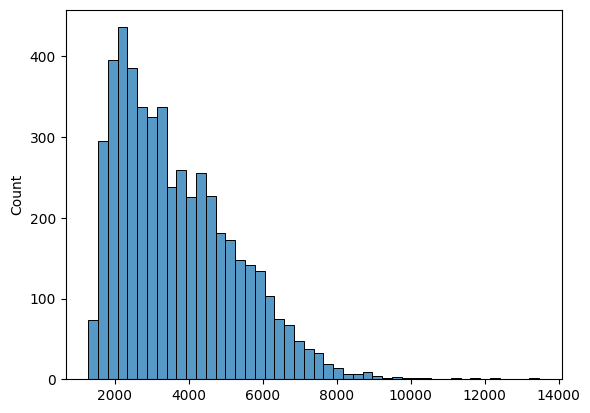

In [ ]:
sns.histplot(text_lengths)
plt.show()

In [ ]:
text_lengths = []

for record in tqdm(billsum_train.select(range(5000))):
  compressed = compress_bill(record["text"], 18)  # added line to show what input size would look like post-compression
  text_lengths.append(len(tokenizer(compressed).input_ids))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:34<00:00, 32.40it/s]


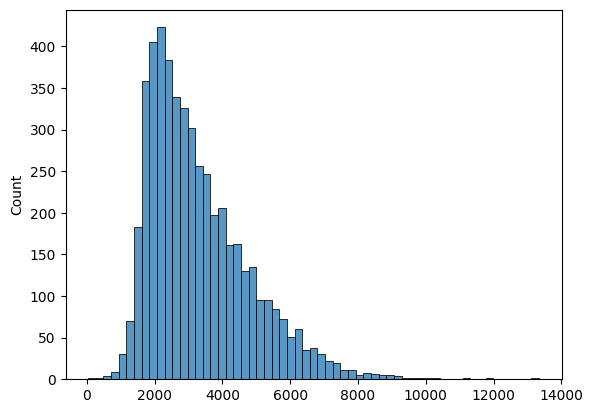

In [ ]:
sns.histplot(text_lengths)
plt.show()

In [ ]:
text_lengths = []

for record in tqdm(billsum_train.select(range(5000))):
  text_lengths.append(len(tokenizer(record["summary"]).input_ids))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 795.25it/s]


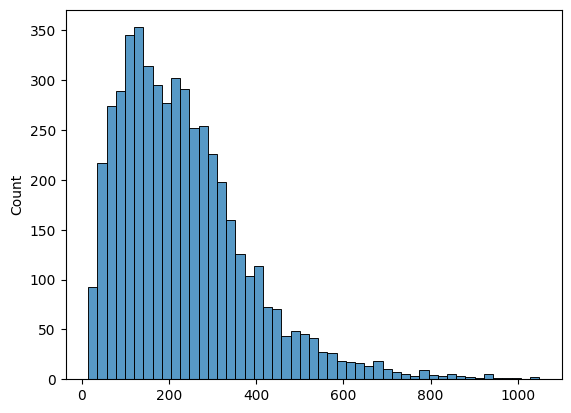

In [ ]:
sns.histplot(text_lengths)
plt.show()

## Load LED Model

In [ ]:
model = LEDForConditionalGeneration.from_pretrained(model_name).to(DEVICE).eval()

# Enable gradient checkpointing to save memory
model.gradient_checkpointing_enable()

## Test Base LED Without Fine Tuning

In [ ]:
def _prepare_batch(batch_texts, max_len_in = 4096):
    """
    Tokenise and attach the global-attention mask required by LED.
    Returns a dict ready for model.generate().
    """
    enc = tokenizer(
        batch_texts,
        padding = "longest",
        truncation = True,
        max_length = max_len_in,
        return_tensors = "pt"
        ).to(DEVICE)

    ga_mask = torch.zeros_like(enc["input_ids"])
    ga_mask[:, 0] = 1
    enc["global_attention_mask"] = ga_mask
    return enc

def generate_led_summaries(data_texts, batch_size = 2, max_len_in = 4096, max_len_out = 288, min_len_out = 48, num_beam = 4, length_pen = 0.8):
    outputs = []
    for i in tqdm(range(0, len(data_texts), batch_size)):
        batch  = data_texts[i: i + batch_size]
        inputs = _prepare_batch(batch, max_len_in = max_len_in)

        with torch.no_grad():
            ids = model.generate(
                **inputs,
                num_beams = num_beam,
                length_penalty = length_pen,
                max_length = max_len_out,
                min_length = min_len_out,
                no_repeat_ngram_size = 3,
                repetition_penalty = 1.05,)

        outputs += tokenizer.batch_decode(ids, skip_special_tokens = True, clean_up_tokenization_spaces = False)

    return outputs

In [ ]:
test_summaries_base = generate_led_summaries(compressed_test_list, batch_size = 24)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [1:16:08<00:00, 33.35s/it]


In [ ]:
rouge = evaluate.load("rouge")

references = [x["summary"] for x in billsum_test]

results = rouge.compute(
    predictions = test_summaries_base,
    references = references)

print(results)

{'rouge1': 0.3369089898226759, 'rouge2': 0.12331491376642478, 'rougeL': 0.2001568283016979, 'rougeLsum': 0.23428011332148596}


In [ ]:
bertscore = evaluate.load("bertscore")

results = bertscore.compute(
    predictions = test_summaries_base,
    references = references,
    lang = "en")

# print(results)

In [ ]:
print(f'Average precision: {np.mean(results["precision"])}')
print(f'Average recall: {np.mean(results["recall"])}')
print(f'Average f1: {np.mean(results["f1"])}')

Average precision: 0.7655603393169309
Average recall: 0.822186723018721
Average f1: 0.7925312731856051


## Create Trainer Cell

###### -- Builds mini batches, pads them to the longest item in the batch, and shifts target tokens so model can compute loss that way.

###### -- Hyper-parameter tuning done to specify batch size, epochs, learning rate, and logging steps.

In [ ]:
def preprocess_function(examples):
    # Tokenize the text
    model_inputs = tokenizer(examples["text"], max_length = 4096, truncation = True)

    # Tokenize the summaries (as labels)
    labels = tokenizer(examples["summary"], max_length = 288, truncation = True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Take a slice of the training data and convert to a standard Dataset
train_slice_size = 5000
train_dataset_slice = billsum_train.select(range(train_slice_size))

# Apply the preprocessing function to the datasets
tokenized_train_data = train_dataset_slice.map(preprocess_function, batched = True)
# tokenized_val_data = billsum_test.map(preprocess_function, batched = True)

# Remove original text and summary columns
tokenized_train_data = tokenized_train_data.remove_columns(["text", "summary", "title"])
# tokenized_val_data = tokenized_val_data.remove_columns(["text", "summary", "title"])

print("Tokenized training data:", tokenized_train_data)
# print("Tokenized validation data:", tokenized_val_data)

Tokenized training data: Dataset({
    features: ['bill_id', 'text_len', 'sum_len', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})


In [ ]:
OUTPUT_PATH = "led_billsum_ft"

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

args = Seq2SeqTrainingArguments(
    output_dir = OUTPUT_PATH,
    # per_device_train_batch_size = 1,
    # per_device_eval_batch_size = 1,
    # gradient_accumulation_steps = 4,
    # num_train_epochs = 1,
    # learning_rate = 5e-5,
    # eval_strategy = "no",
    # predict_with_generate = True,
    # logging_steps = 100,
    # max_steps = 5000,
    eval_strategy="no",           # No validation during training
    save_strategy="steps",
    save_steps=20,
    save_total_limit=2,
    per_device_train_batch_size=24,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    fp16=True,                          # Mixed precision
    logging_steps=10,
    logging_dir="./logs",
    report_to="none",                   # Disable wandb/hf logging
    predict_with_generate=False
)

trainer = Seq2SeqTrainer(
    model = model,
    args = args,
    train_dataset = tokenized_train_data,
    data_collator = data_collator
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
# Check if there is a checkpoint to resume training from
checkpoint = None
if os.path.isdir(OUTPUT_PATH):
    checkpoints = [os.path.join(OUTPUT_PATH, d) for d in os.listdir(OUTPUT_PATH)]
    checkpoints = [c for c in checkpoints if os.path.isdir(c) and c.startswith(os.path.join(OUTPUT_PATH, "checkpoint"))]
    if checkpoints:
        # Sort to get latest checkpoint by modification time
        checkpoints = sorted(checkpoints, key=os.path.getmtime)
        checkpoint = checkpoints[-1]
        print(f"Found checkpoint {checkpoint}, resuming training from checkpoint.")

Found checkpoint led_billsum_ft/checkpoint-20, resuming training from checkpoint.


In [ ]:
trainer.train(resume_from_checkpoint=checkpoint)

There were missing keys in the checkpoint model loaded: ['led.encoder.embed_tokens.weight', 'led.decoder.embed_tokens.weight', 'lm_head.weight'].


Step,Training Loss
30,1.838800
40,1.788000
50,1.725900


TrainOutput(global_step=52, training_loss=1.1048959768735445, metrics={'train_runtime': 953.7189, 'train_samples_per_second': 5.243, 'train_steps_per_second': 0.056, 'total_flos': 1.350102417408e+16, 'train_loss': 1.1048959768735445, 'epoch': 0.9952153110047847})

In [ ]:
model.save_pretrained(OUTPUT_PATH)
# tokenizer.save_pretrained("led_billsum_ft")

In [ ]:
model = LEDForConditionalGeneration.from_pretrained(OUTPUT_PATH).to(DEVICE).eval()

In [ ]:
model.eval()
ft_summaries = generate_led_summaries(compressed_test_list, batch_size = 32)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [1:09:49<00:00, 40.67s/it]


In [ ]:
rouge = evaluate.load('rouge')

references = [x["summary"] for x in billsum_test]

results_fine_tuned = rouge.compute(
    predictions = ft_summaries,
    references = references)

print(results_fine_tuned)

{'rouge1': 0.43758203889405234, 'rouge2': 0.262947006371139, 'rougeL': 0.3229160108997129, 'rougeLsum': 0.35987622734110347}


In [ ]:
bertscore = evaluate.load('bertscore')

results_fine_tuned = bertscore.compute(
    predictions = ft_summaries,
    references = references,
    lang = "en")

# print(results_fine_tuned)

In [ ]:
print(f'Average precision: {np.mean(results_fine_tuned["precision"])}')
print(f'Average recall: {np.mean(results_fine_tuned["recall"])}')
print(f'Average f1: {np.mean(results_fine_tuned["f1"])}')

Average precision: 0.8931426483945184
Average recall: 0.8659068470739305
Average f1: 0.8788196471132026


In [ ]:
for i, record in enumerate(billsum_test):
  if i >= 5:
    break

  print(f"Example #{ i + 1 }")
  print("Title:", record["title"])
  print("Reference:", record["summary"])
  print("Candidate:", ft_summaries[i])
  print()

Example #1
Title: To make technical corrections to the Water Resources Development Act of 1999.
Reference: Amends the Water Resources Development Act of 1999 to: (1) authorize appropriations for FY 1999 through 2009 for implementation of a long-term resource monitoring program with respect to the Upper Mississippi River Environmental Management Program (currently, such funding is designated for a program for the planning, construction, and evaluation of measures for fish and wildlife habitat rehabilitation and enhancement); (2) authorize the Secretary of the Army to carry out modifications to the navigation project for the Delaware River, Pennsylvania and Delaware, if such project as modified is technically sound, environmentally (currently, economically) acceptable, and economically justified; (3) subject certain previously deauthorized water resources development projects to the seven-year limitation governing project deauthorizations under the Act, with the exception of such a proje